In [3]:
#import the necessary packages
import torch
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss
from torchvision import transforms
from torch.utils.data import DataLoader
# base path of the dataset
# from pyimagesearch.model import UNet
DATASET_PATH = "/data/DeepSense6G/stationary_scenarios/scenario31/generated_dataset"

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "radar")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "lidar")



In [4]:
# define the test split
TEST_SPLIT = 0.15

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "examples/PyTorch_tutorial/output"
# define the path to the output serialized model, model training
# plot, and testing image paths
# MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
# PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [5]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2
import numpy as np

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
		
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		maskPath = self.maskPaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = np.load(imagePath)
		
		mask = np.load(maskPath)
		
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			# state = torch.get_rng_state()
			transformed = self.transforms(image=image, mask=mask)
			image = transformed["image"]
			
			mask = transformed["mask"]
			
		# return a tuple of the image and its mask
		return (image, mask)


In [6]:
import numpy as np
from os import listdir



def list_files(directory, extension):
    return (os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(extension))


directory_im = IMAGE_DATASET_PATH
directory_mas = MASK_DATASET_PATH
extension = '.npy'


imagePaths = sorted(list_files(directory_im, extension))
maskPaths = sorted(list_files(directory_mas, extension))

split = train_test_split(imagePaths, maskPaths,
	test_size=0.15, random_state=42)

(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

In [7]:
import albumentations as A

In [47]:
#from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import PIL
transforms = A.Compose([A.Resize(284, 284, always_apply=True), A.RandomCrop(height=256, width = 256, p=1), A.RandomRotate90(p=0), ToTensorV2(transpose_mask=False)])

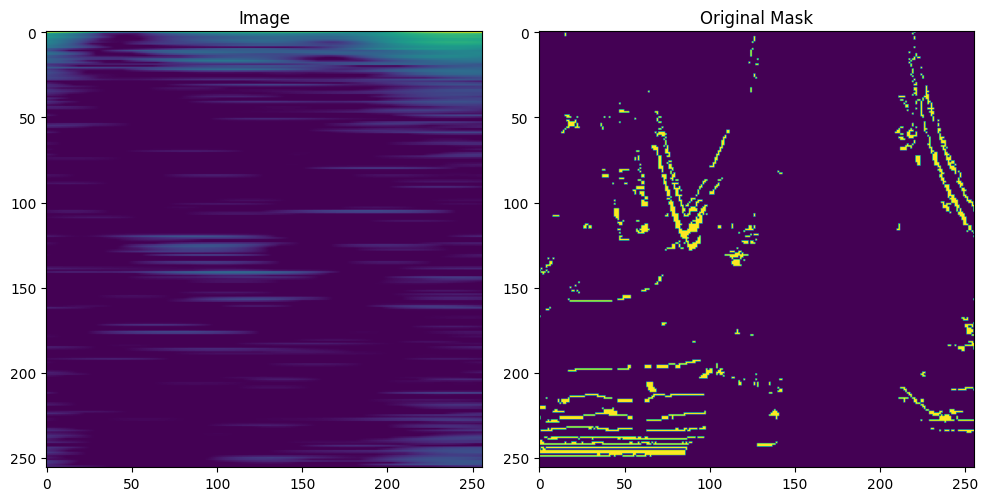

In [48]:
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
trainDS[0][1].shape

import matplotlib.pyplot as plt
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
	
# plot the original image, its mask, and the predicted mask
ax[0].imshow(trainDS[0][0][0].numpy())
ax[1].imshow(trainDS[0][1].numpy())

# set the titles of the subplots
ax[0].set_title("Image")
ax[1].set_title("Original Mask")


# set the layout of the figure and display it
figure.tight_layout()
figure.show()

In [49]:
trainDS[0][1].shape, len(trainDS)

(torch.Size([256, 256]), 5960)

In [29]:
from pyimagesearch import config
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 5960 examples in the training set...
[INFO] found 1052 examples in the test set...


In [30]:
# import the necessary packages

from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
		
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))
	
class Encoder(Module):
	def __init__(self, channels=(3,16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
		
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
			
		# return the list containing the intermediate outputs
		return blockOutputs
	

class Decoder(Module):
	def __init__(self, channels=(  64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		
		# return the cropped features
		return encFeatures



class UNet(Module):
    def __init__(self, encChannels=(3,16,32, 64),
         decChannels=(64, 32, 16),
         nbClasses=1, retainDim=True,
         outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
	
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
	
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
	
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])
	
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
       
	
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
	    
        # return the segmentation map
        return map


In [31]:
from torch.optim import Adam
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
unet = UNet().to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE
H = {"train_loss": [], "test_loss": []}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()

[INFO] training the network...


In [32]:
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [33]:
from torch.cuda import empty_cache
import matplotlib.pyplot as plt
empty_cache()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		
		# send the input to the device
		(x, y) = (x.to(config.DEVICE).float(), y.to(config.DEVICE).float())
		
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		
		# loop over the validation set
		for (x, y) in testLoader:
			
			# send the input to the device
			(x, y) = (x.to(config.DEVICE).float(), y.to(config.DEVICE).float())
			
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
	
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:03<?, ?it/s]


ValueError: Target size (torch.Size([64, 256, 256])) must be the same as input size (torch.Size([64, 1, 256, 256]))

FileNotFoundError: [Errno 2] No such file or directory: 'examples/PyTorch_tutorial/output/plot.png'

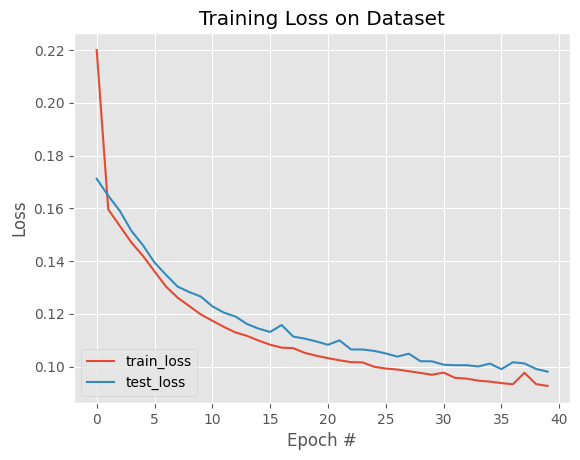

In [15]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)

In [17]:
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=6, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=6, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())

In [18]:
import os
os.getcwd()

'/home/amir/Documents/radar-dev/examples/PyTorch_tutorial'

In [19]:
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])


print("[INFO] saving testing image paths...")
print(os.getcwd())
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...
/home/amir/Documents/radar-dev/examples/PyTorch_tutorial


In [20]:
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

In [21]:
image = np.load(imagePaths[0])
filename = imagePaths[0].split(os.path.sep)[-1]
groundTruthPath = os.path.join(config.MASK_DATASET_PATH,filename)
gt_mask = np.load(groundTruthPath)
image = np.transpose(image, (2, 0, 1))
image = np.expand_dims(image, 0)
image = torch.from_numpy(image).to(config.DEVICE).float()
predMask = unet(image).squeeze()
predMask = torch.sigmoid(predMask)
predMask = predMask.cpu().detach().numpy()


[INFO] loading up test image paths...
[INFO] load up model...
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


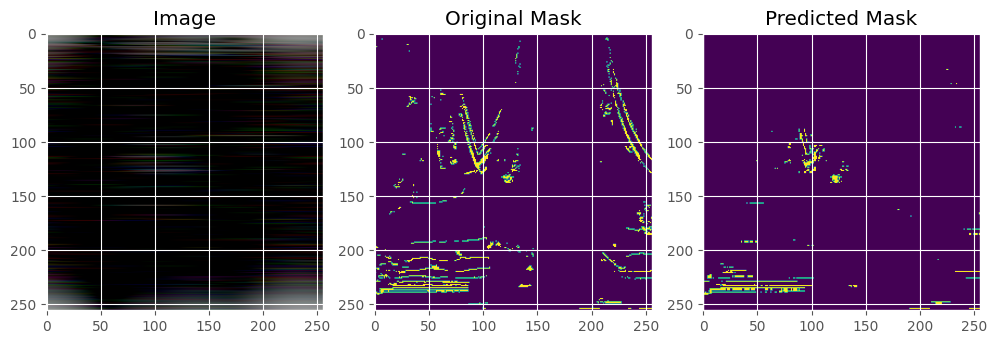

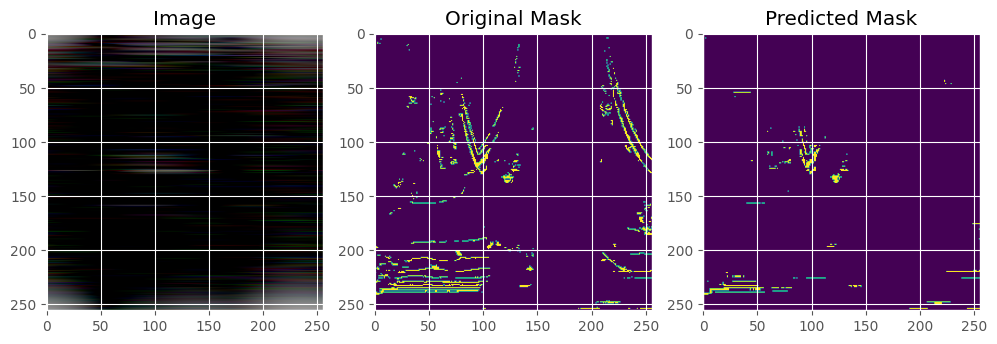

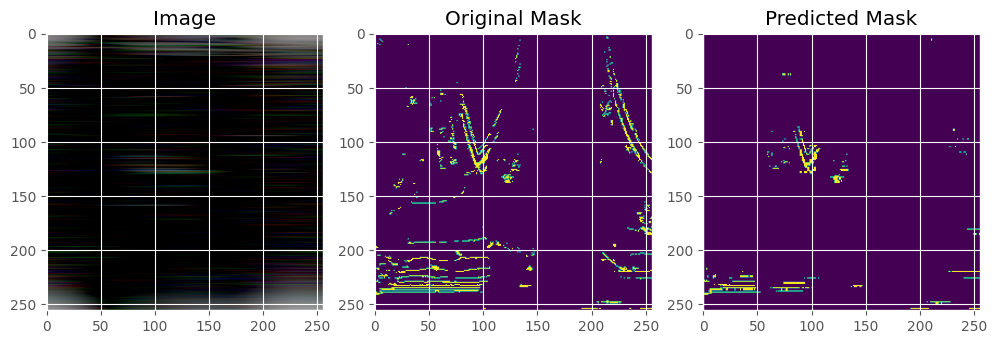

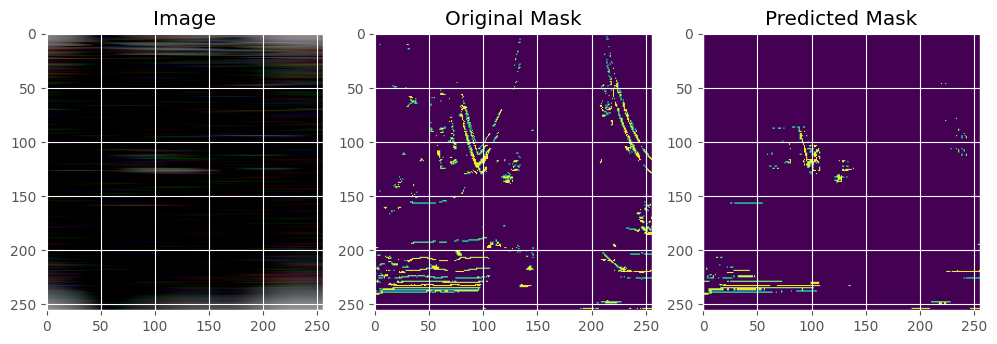

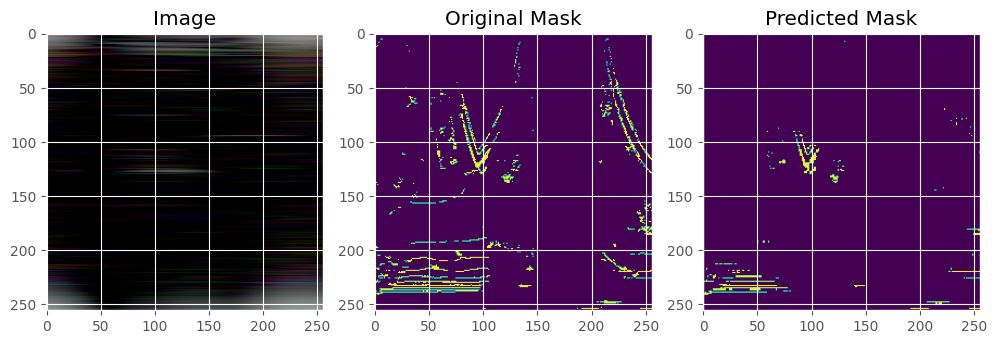

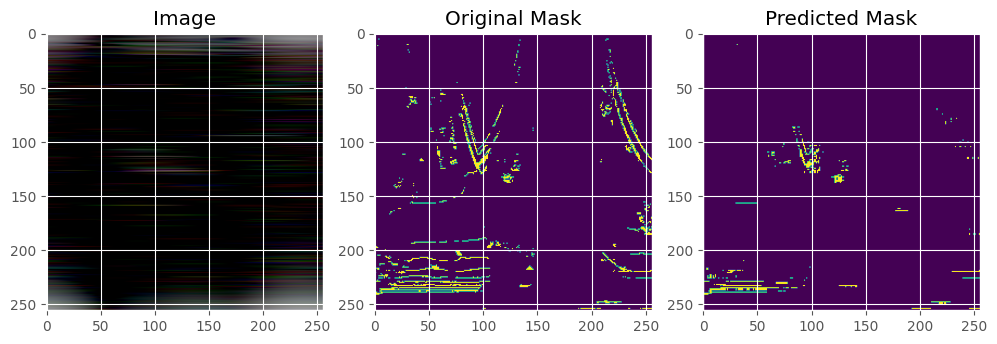

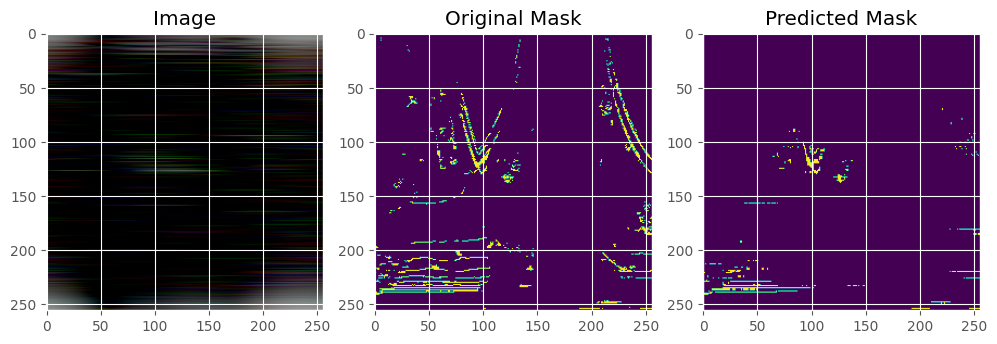

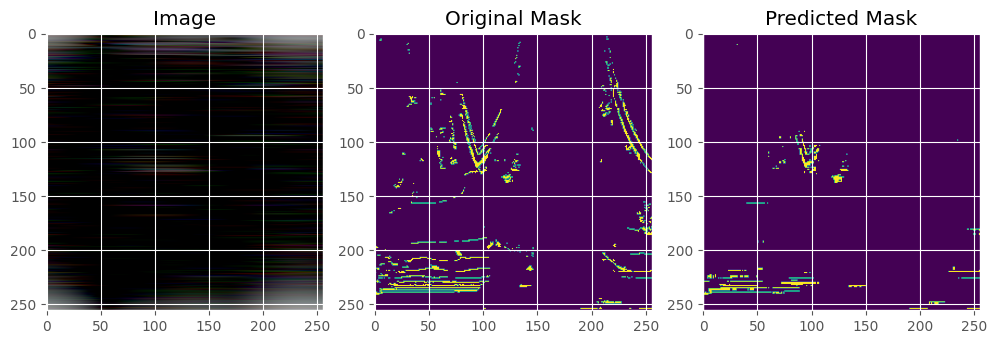

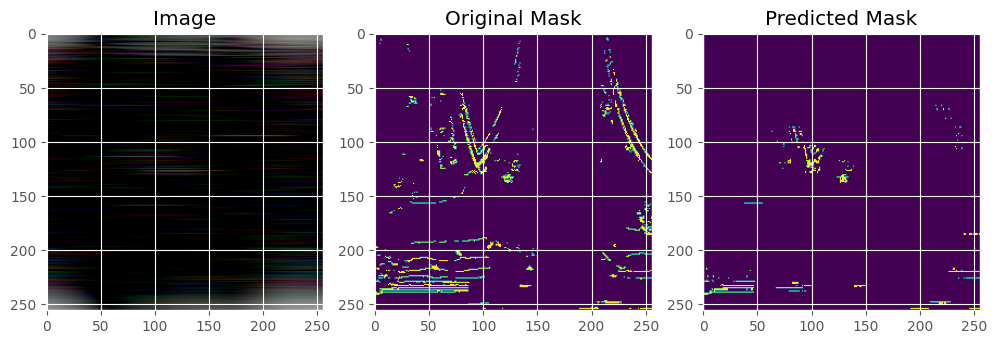

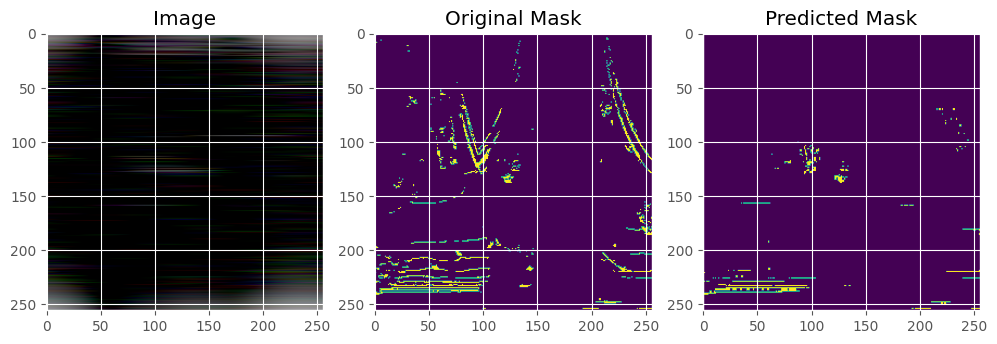

: 

In [23]:

# USAGE
# python predict.py

# import the necessary packages
from pyimagesearch import config
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
	


def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = np.load(imagePath)
	
		
		
		orig = image.copy()
		
		# find the filename and generate the path to ground truth
		# mask

		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
			filename)
		
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = np.load(groundTruthPath, 0)* 255
		
		
		
        # make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image =  torch.from_numpy(image).to(config.DEVICE).float()
		
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > config.THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)
		
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
# unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)

In [ ]:
inputs, classes = next(iter(trainLoader)) 

In [ ]:
unet(x.to(config.DEVICE).float())[0]

In [ ]:
for (x, y) in testLoader:
    
    # send the input to the device
    (x, y) = (x.to(config.DEVICE).float(), y.to(config.DEVICE).float())